<a href="https://colab.research.google.com/github/jd2504/bme_dsp_2025/blob/main/10_lpc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import os
# import sys

# bme_repo = "https://github.com/jd2504/bme_dsp_2025.git"
# repo_name = bme_repo.split('/')[-1].replace('.git', '')
# !git clone {bme_repo}
# sys.path.append(os.path.join(os.getcwd(), repo_name))
# import bmedsp_helpers as bme

# Stochastic Process - AR and LPC

In [2]:
import numpy as np
from scipy import stats, signal, fft
from scipy.linalg import toeplitz, solve, solve_toeplitz

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold

from tqdm import tqdm

from matplotlib import pyplot as plt

In [3]:
import pandas as pd

# 2 yrs of new york hourly energy data: FY2020-FY2021
f = "https://raw.githubusercontent.com/carbonfirst/CarbonCast/refs/heads/main/data/NYISO/NYISO_direct_emissions.csv"
ny = pd.read_csv(f)

In [4]:
ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        17544 non-null  int64  
 1   UTC time          17544 non-null  object 
 2   carbon_intensity  17544 non-null  float64
 3   nat_gas           17544 non-null  int64  
 4   nuclear           17544 non-null  int64  
 5   oil               17544 non-null  int64  
 6   hydro             17544 non-null  int64  
 7   wind              17544 non-null  int64  
 8   other             17544 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 1.2+ MB


In [5]:
factor = "nuclear"

t = ny["UTC time"]
x = ny[factor].to_numpy()

/tmp/ipython-input-4265624581.py:20: RuntimeWarning: divide by zero encountered in log10
  10*np.log10(Sxx),


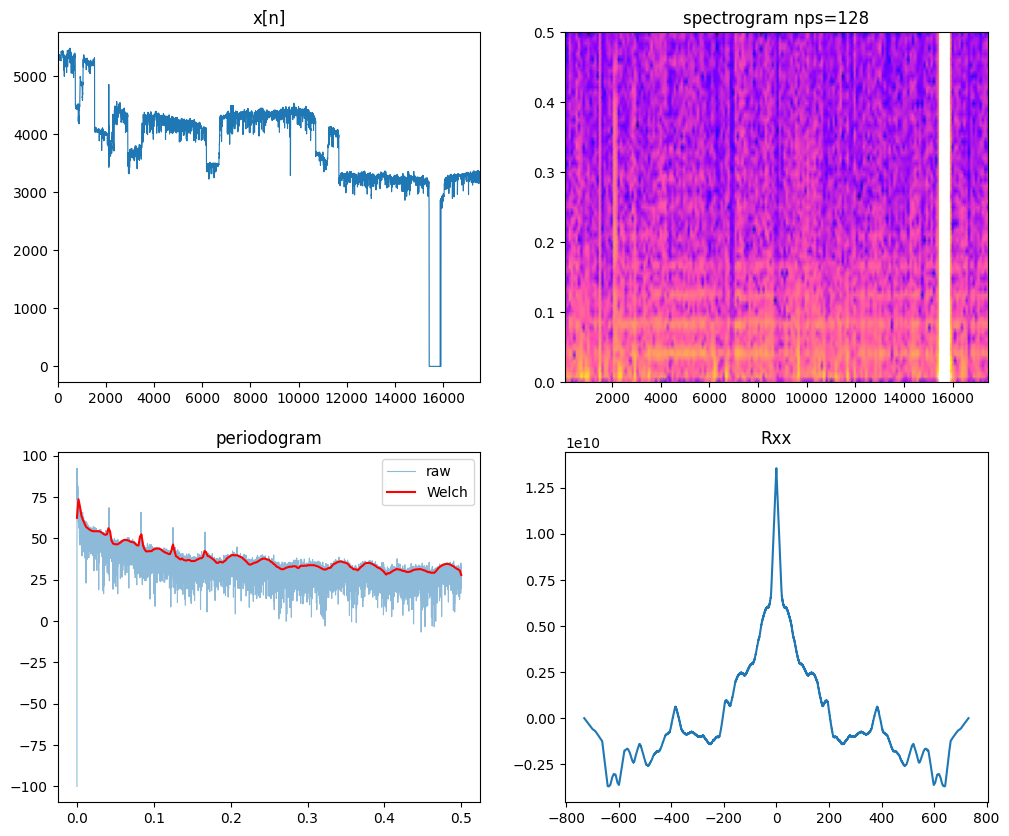

In [6]:
fs = 1
N = len(x)

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title('x[n]')
plt.plot(x, linewidth=0.8)
plt.xlim(0, N)


# spectrogram
nps=128

plt.subplot(2, 2, 2)
plt.title(f'spectrogram nps={nps}')

f_spec, t_spec, Sxx = signal.spectrogram(x, fs, nperseg=nps, noverlap=32)
plt.pcolormesh(t_spec, f_spec,
               10*np.log10(Sxx),
               shading='gouraud', cmap='gnuplot2')


# welch/periodogram
plt.subplot(2, 2, 3)
plt.title('periodogram')

X_fft = np.fft.fft(x - np.mean(x))
Px = (np.abs(X_fft) ** 2) / N
freqs = np.fft.fftfreq(N)
real_mask = freqs>=0

plt.plot(freqs[freqs>=0],
         10*np.log10(Px[real_mask]+1e-10),
         lw=0.8, alpha=0.5, label='raw')

f_welch, P_welch = signal.welch(x-np.mean(x), fs, nperseg=512)
plt.plot(f_welch,
         10*np.log10(P_welch),
         c='r', label='Welch')
plt.legend()



# autocorrelation
plt.subplot(2, 2, 4)
plt.title('Rxx')

x_centered = x - np.mean(x)
rxx = np.correlate(x_centered, x_centered, mode='full')
lags = np.arange(-N + 1, N)/24

plt.plot(lags, rxx)


plt.show()

$ e[n] = x[n]-\hat{x}[n] $

$ e[n] = x[n] - \left( -\sum_{k=1}^{P} a[k]x[n-k] \right) $

$ e[n] = x[n] + \sum_{k=1}^{P} a[k]x[n-k] $

ar normal equation:

$ R_{xx} a=−r x $

# AR model

In [7]:
x_train_raw, x_test_raw = train_test_split(x, test_size=0.2, shuffle=False)

mu = np.mean(x_train_raw)
x_train = x_train_raw - mu
x_test = x_test_raw - mu

test_mse = []

rxx_full = np.correlate(x_train, x_train, mode='full')
rxx_full = rxx_full / rxx_full[0]
r_train = rxx_full[len(rxx_full)//2:]


test_P = range(50, 700)

for k in tqdm(test_P):
    rxx_iter = toeplitz(r_train[:k])
    r_vec = r_train[1:k+1]
    a_coeffs = solve(rxx_iter, -r_vec)

    A_filter = np.concatenate(([1.0], a_coeffs))


    # error ... concat <- edge artifacts
    hist = np.concatenate((x_train[-k:], x_test))

    # filter: e[n] = A(z) * x[n]
    e_full = signal.lfilter(A_filter, [1.0], hist)
    e_test = e_full[k:] # dump 'history' part of error

    mse = np.mean(e_test**2)

    test_mse.append(mse)
    print(f"{k:<10} | {mse:.5f}")

 24%|██▍       | 157/650 [00:00<00:00, 787.18it/s]

50         | 9669.84491
51         | 9663.31124
52         | 9652.49846
53         | 9635.90448
54         | 9645.23025
55         | 9644.33580
56         | 9647.03187
57         | 9654.03241
58         | 9656.95335
59         | 9658.18806
60         | 9658.07716
61         | 9658.07697
62         | 9657.77254
63         | 9657.14157
64         | 9653.28697
65         | 9649.28132
66         | 9649.17297
67         | 9645.59977
68         | 9643.19912
69         | 9641.55227
70         | 9663.68143
71         | 9655.19920
72         | 9628.80310
73         | 9598.86973
74         | 9586.47713
75         | 9592.92130
76         | 9592.66916
77         | 9596.31942
78         | 9598.50768
79         | 9603.00249
80         | 9603.25095
81         | 9603.01351
82         | 9603.90761
83         | 9603.31106
84         | 9605.79108
85         | 9607.73208
86         | 9610.22191
87         | 9610.44170
88         | 9610.38162
89         | 9608.58305
90         | 9604.79464
91         | 960

 36%|███▋      | 236/650 [00:00<00:00, 577.87it/s]

216        | 9494.29295
217        | 9486.00808
218        | 9483.98788
219        | 9486.94109
220        | 9485.89259
221        | 9491.73699
222        | 9495.81155
223        | 9493.26381
224        | 9495.61841
225        | 9499.06197
226        | 9498.97552
227        | 9500.06631
228        | 9501.24424
229        | 9500.72214
230        | 9500.68143
231        | 9499.10421
232        | 9502.67641
233        | 9502.27471
234        | 9502.86502
235        | 9501.96958
236        | 9501.49152
237        | 9500.99814
238        | 9502.76315
239        | 9502.13958
240        | 9501.12787
241        | 9480.78905
242        | 9477.64340
243        | 9479.40387
244        | 9479.78565
245        | 9479.24171
246        | 9480.03393
247        | 9481.15767
248        | 9480.52686
249        | 9486.90669
250        | 9487.31160
251        | 9487.04955
252        | 9487.44762
253        | 9490.13351
254        | 9488.94832
255        | 9489.35964
256        | 9489.24636
257        | 949

 46%|████▌     | 299/650 [00:00<00:00, 355.68it/s]

340        | 9511.13000
341        | 9510.95793
342        | 9512.37911
343        | 9513.61703
344        | 9513.42593
345        | 9514.11961
346        | 9513.46988
347        | 9513.19682
348        | 9513.35236
349        | 9513.56316
350        | 9513.40776
351        | 9516.52153
352        | 9518.09735
353        | 9516.85741
354        | 9519.41647
355        | 9519.31844
356        | 9527.15425
357        | 9528.08840
358        | 9528.98414
359        | 9529.01935
360        | 9527.70529
361        | 9526.19848
362        | 9523.10184
363        | 9522.99531
364        | 9522.36527
365        | 9520.62440
366        | 9523.06101
367        | 9523.27529
368        | 9523.72710
369        | 9524.38656
370        | 9524.27238
371        | 9524.00461
372        | 9523.99949
373        | 9524.28109
374        | 9523.63526
375        | 9524.38475
376        | 9523.53051
377        | 9523.52731
378        | 9521.90840
379        | 9523.05749
380        | 9522.62392
381        | 952

 53%|█████▎    | 346/650 [00:01<00:01, 240.94it/s]

394        | 9521.70518
395        | 9521.39746
396        | 9521.42868
397        | 9523.90252
398        | 9523.81782
399        | 9523.52330
400        | 9523.39711
401        | 9524.27759
402        | 9524.14177
403        | 9523.63252
404        | 9523.74029
405        | 9524.00500
406        | 9524.33516
407        | 9524.39428
408        | 9523.76681
409        | 9522.61245
410        | 9522.45044
411        | 9523.88232
412        | 9525.41842
413        | 9525.75985
414        | 9527.17026
415        | 9526.61359
416        | 9526.74942
417        | 9526.39050
418        | 9525.84349
419        | 9525.52052
420        | 9524.81359


 59%|█████▊    | 381/650 [00:01<00:01, 198.38it/s]

421        | 9524.45924
422        | 9523.66247
423        | 9524.55717
424        | 9525.18444
425        | 9526.65376
426        | 9526.78051
427        | 9529.06029
428        | 9528.38221
429        | 9529.45051
430        | 9530.57776
431        | 9530.05344
432        | 9530.01200
433        | 9534.37724
434        | 9534.83076
435        | 9545.81575
436        | 9545.97477
437        | 9545.83264
438        | 9545.77768
439        | 9545.73894
440        | 9545.38143
441        | 9545.24947
442        | 9544.47042
443        | 9543.86412


 63%|██████▎   | 408/650 [00:01<00:01, 171.45it/s]

444        | 9543.78181
445        | 9544.17444
446        | 9544.05629
447        | 9544.41902
448        | 9544.41180
449        | 9545.37073
450        | 9544.76680
451        | 9544.67721
452        | 9543.73439
453        | 9547.68606
454        | 9549.39737
455        | 9548.13043
456        | 9548.14845
457        | 9539.86071
458        | 9539.21119
459        | 9539.20702
460        | 9541.61214
461        | 9541.91942
462        | 9541.98326
463        | 9527.67636
464        | 9527.07218
465        | 9523.13332


 66%|██████▌   | 430/650 [00:01<00:01, 149.54it/s]

466        | 9522.45538
467        | 9521.28462
468        | 9519.07155
469        | 9524.17582
470        | 9530.70757
471        | 9532.34680
472        | 9535.72492
473        | 9537.40264
474        | 9535.95857
475        | 9536.24274
476        | 9536.49995
477        | 9537.79887
478        | 9538.07579
479        | 9539.58734
480        | 9539.23802
481        | 9539.28151
482        | 9542.71234
483        | 9551.56716
484        | 9552.70667
485        | 9554.48823


 69%|██████▉   | 448/650 [00:02<00:01, 128.66it/s]

486        | 9553.39569
487        | 9547.84575
488        | 9549.18406
489        | 9549.81696
490        | 9553.56596
491        | 9552.84029
492        | 9544.96972
493        | 9553.08190
494        | 9541.70319
495        | 9540.62250
496        | 9536.95407
497        | 9534.69421
498        | 9533.95367
499        | 9530.08746
500        | 9531.46003


 71%|███████   | 463/650 [00:02<00:01, 116.77it/s]

501        | 9530.51187
502        | 9523.94809
503        | 9526.00347
504        | 9540.80510
505        | 9550.77716
506        | 9551.33508
507        | 9552.66034
508        | 9550.83858
509        | 9550.53741
510        | 9550.20964
511        | 9549.22101
512        | 9551.30789
513        | 9551.46632
514        | 9553.10336
515        | 9551.65877
516        | 9545.56739
517        | 9545.36545


 73%|███████▎  | 476/650 [00:02<00:01, 106.72it/s]

518        | 9550.33045
519        | 9553.75408
520        | 9553.56337
521        | 9553.97077
522        | 9553.15987
523        | 9555.19551
524        | 9557.51811
525        | 9557.45764
526        | 9558.39204
527        | 9558.45212
528        | 9556.25281
529        | 9553.07494
530        | 9553.68284
531        | 9553.45188
532        | 9555.21956
533        | 9553.73861


 77%|███████▋  | 498/650 [00:02<00:01, 92.18it/s]

534        | 9553.28651
535        | 9550.70438
536        | 9549.93125
537        | 9549.73128
538        | 9548.94300
539        | 9551.08433
540        | 9550.93370
541        | 9551.48033
542        | 9551.46480
543        | 9552.30519
544        | 9554.25679
545        | 9553.59353
546        | 9553.25356
547        | 9554.83117
548        | 9553.47996


 78%|███████▊  | 508/650 [00:02<00:01, 85.33it/s]

549        | 9550.60062
550        | 9551.17667
551        | 9559.90616
552        | 9561.33860
553        | 9556.00087
554        | 9556.03336
555        | 9556.39466
556        | 9553.39636
557        | 9553.77804
558        | 9554.75094
559        | 9554.48013
560        | 9554.97496
561        | 9553.35170
562        | 9553.35551
563        | 9553.46184


 81%|████████  | 525/650 [00:03<00:01, 72.38it/s]

564        | 9553.08406
565        | 9553.06612
566        | 9552.42419
567        | 9552.62784
568        | 9557.73538
569        | 9557.09501
570        | 9558.30223
571        | 9558.15830
572        | 9557.34529
573        | 9556.56042
574        | 9555.94019
575        | 9557.24715


 82%|████████▏ | 533/650 [00:03<00:01, 68.27it/s]

576        | 9557.77225
577        | 9558.80402
578        | 9559.04787
579        | 9559.30063
580        | 9558.76465
581        | 9558.96414
582        | 9558.81334
583        | 9558.60005
584        | 9559.33071
585        | 9559.08113
586        | 9558.97184
587        | 9558.60866
588        | 9559.21165


 84%|████████▍ | 547/650 [00:03<00:01, 62.44it/s]

589        | 9558.48732
590        | 9556.46772
591        | 9574.80540
592        | 9584.63951
593        | 9583.06490
594        | 9584.85907
595        | 9584.51037
596        | 9584.44711
597        | 9583.89368
598        | 9583.83914
599        | 9585.70305


 86%|████████▌ | 560/650 [00:03<00:01, 56.94it/s]

600        | 9592.02533
601        | 9593.57386
602        | 9596.26312
603        | 9599.59214
604        | 9599.20057
605        | 9597.71594
606        | 9597.04019
607        | 9597.70714
608        | 9597.08575
609        | 9597.15475
610        | 9596.89395


 88%|████████▊ | 572/650 [00:04<00:01, 53.76it/s]

611        | 9598.43783
612        | 9598.64045
613        | 9598.22309
614        | 9598.09582
615        | 9596.06055
616        | 9596.23809
617        | 9601.44986
618        | 9601.20164
619        | 9601.64315
620        | 9617.06030
621        | 9614.26808


 89%|████████▉ | 578/650 [00:04<00:01, 49.04it/s]

622        | 9616.34289
623        | 9621.85114
624        | 9623.58789
625        | 9615.55020
626        | 9625.12345
627        | 9626.77650
628        | 9626.56769
629        | 9625.93668
630        | 9625.43038
631        | 9627.20637


 90%|█████████ | 588/650 [00:04<00:01, 48.46it/s]

632        | 9626.66067
633        | 9626.91083
634        | 9627.07513
635        | 9627.43019
636        | 9624.52405
637        | 9624.90050
638        | 9622.75063
639        | 9621.07798
640        | 9622.69950
641        | 9623.52401


 92%|█████████▏| 598/650 [00:04<00:01, 47.75it/s]

642        | 9623.12590
643        | 9623.09293
644        | 9623.12232
645        | 9624.47204
646        | 9624.66304
647        | 9626.62629
648        | 9627.05286
649        | 9619.77092
650        | 9623.42712
651        | 9626.26516


 94%|█████████▎| 608/650 [00:04<00:00, 46.88it/s]

652        | 9625.85956
653        | 9625.38630
654        | 9629.50721
655        | 9628.46553
656        | 9628.60288
657        | 9628.82670
658        | 9629.76909
659        | 9629.00433
660        | 9628.74187
661        | 9629.22269


 95%|█████████▌| 618/650 [00:05<00:00, 45.08it/s]

662        | 9625.51867
663        | 9626.19541
664        | 9626.38489
665        | 9625.24123
666        | 9625.38291
667        | 9629.17285
668        | 9630.98375
669        | 9631.36215
670        | 9631.51037


 97%|█████████▋| 628/650 [00:05<00:00, 40.78it/s]

671        | 9636.00249
672        | 9636.38592
673        | 9633.31472
674        | 9633.24658
675        | 9633.36971
676        | 9631.84276
677        | 9633.30530
678        | 9633.34405
679        | 9638.60344


 98%|█████████▊| 638/650 [00:05<00:00, 41.39it/s]

680        | 9640.45066
681        | 9645.80273
682        | 9646.88826
683        | 9646.40741
684        | 9647.09608
685        | 9647.06150
686        | 9647.91518
687        | 9647.44908
688        | 9647.45685


 99%|█████████▉| 643/650 [00:05<00:00, 41.07it/s]

689        | 9646.90366
690        | 9646.19355
691        | 9646.27449
692        | 9647.52078
693        | 9647.70761
694        | 9652.85199
695        | 9653.14373
696        | 9653.55646


100%|██████████| 650/650 [00:05<00:00, 110.55it/s]

697        | 9651.57257
698        | 9650.57158
699        | 9651.68879


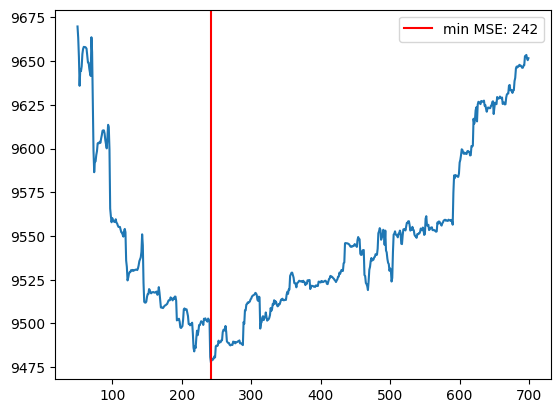

In [8]:
min_idx = np.argmin(test_mse)

P_best = test_P[min_idx]

plt.plot(test_P, test_mse)
plt.axvline(P_best, c='r', label=f"min MSE: {P_best}")
# plt.title(f"min MSE: {P_vals[min_idx]}")
plt.legend()
plt.show()

In [9]:
rxx_mat = toeplitz(rxx_full[:P_best])
r_vec = rxx_full[1:P_best+1]
a_coeffs = solve(rxx_mat, -r_vec)
ar_filt = np.concatenate(([1.0], a_coeffs))

`np.var(innovation_process)` : $E$

$ \epsilon = E[|e[n]|^2] $

link coeffs $a[l]$ and $r_{x}$ : $ \sum_{l=0}^{P} a[l]r_x[k-l] = \epsilon \delta (k) $

for lag k=0, error power: $ \epsilon = \sum_{l=0}^{P} a[l]r_x[-l] $ (lpc g output)

In [11]:
ar_inproc = signal.lfilter(ar_filt, [1], x_centered)
g = np.var(ar_inproc[len(ar_filt):])

print(f"innovation var (sigma^2): {g}")

innovation var (sigma^2): 7503.150918612742


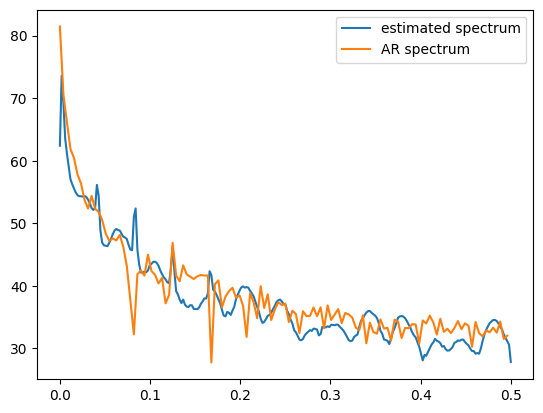

In [12]:
w, h = signal.freqz(1, ar_filt, worN=128)
f_ar = w / (2 * np.pi) # fr rads to freq
P_ar = g * (np.abs(h) ** 2)

f_welch, P_welch = signal.welch(x_centered, fs, nperseg=512)

plt.plot(f_welch, 10*np.log10(P_welch), label="estimated spectrum")
plt.plot(f_ar, 10*np.log10(P_ar), label="AR spectrum")

plt.legend()

plt.show()

# LPC

In [13]:
def lpc(x, p):
    n = len(x)
    r = np.correlate(x, x, mode='full')
    r = r / n

    mid = len(r) // 2
    # lags 0:P
    r_lags = r[mid:mid+p+1]

    # Yule-Walker r*a_coeffs = -r_rhs
    # r: toeplitz r[0]...r[p-1]
    # r_rhs: r[1]...r[p]

    toeplitz_col = r_lags[:-1] # 0:p-1
    rhs = -r_lags[1:] # 1:p

    a_coeffs = solve_toeplitz((toeplitz_col, toeplitz_col), rhs)
    a = np.concatenate(([1], a_coeffs))

    # g = r(0) + sum(a_k * r(k)) for k=1 to p
    # dot prod of full coeffs vector and rxx
    g = np.dot(a, r_lags)

    return a, np.abs(g)

In [14]:
a_lpc, lpc_var = lpc(x, P_best)

In [15]:
lpc_var

np.float64(5035.813096585538)

In [16]:
lpc_filt = signal.lfilter(a_lpc, [1], x_centered)

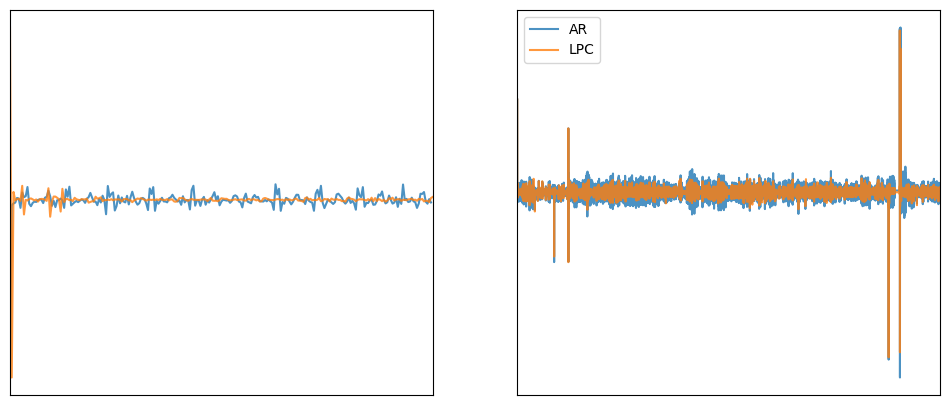

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(a_coeffs, alpha=0.8, label="AR")
plt.plot(a_lpc, alpha=0.8, label="LPC")
plt.xticks([])
plt.yticks([])
plt.xlim(0,len(a_coeffs))
# plt.legend()

plt.subplot(1,2,2)
plt.plot(ar_inproc, alpha=0.8, label="AR")
plt.plot(lpc_filt, alpha=0.8, label="LPC")
plt.xticks([])
plt.yticks([])
plt.xlim(0,len(ar_inproc))
plt.legend()
plt.show()

# SNR

$$ SNR = \frac{\sum_n |\hat{x}[n]|^2}{\sum_n |e[n]|^2} $$

In [18]:
x_pred = x_centered-ar_inproc

# SNR = sum(|x_hat|^2) / sum(|e|^2)
power_pred = np.sum(x_pred**2)
power_e = np.sum(ar_inproc**2)
snr = 10*np.log10(power_pred / power_e)

print(f"SNR: {snr:.2f} dB")

SNR: 20.17 dB


<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-2489661790.py:12: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(x_pred[zoom], 'r--', label='prediction $\hat{x}[n]$')


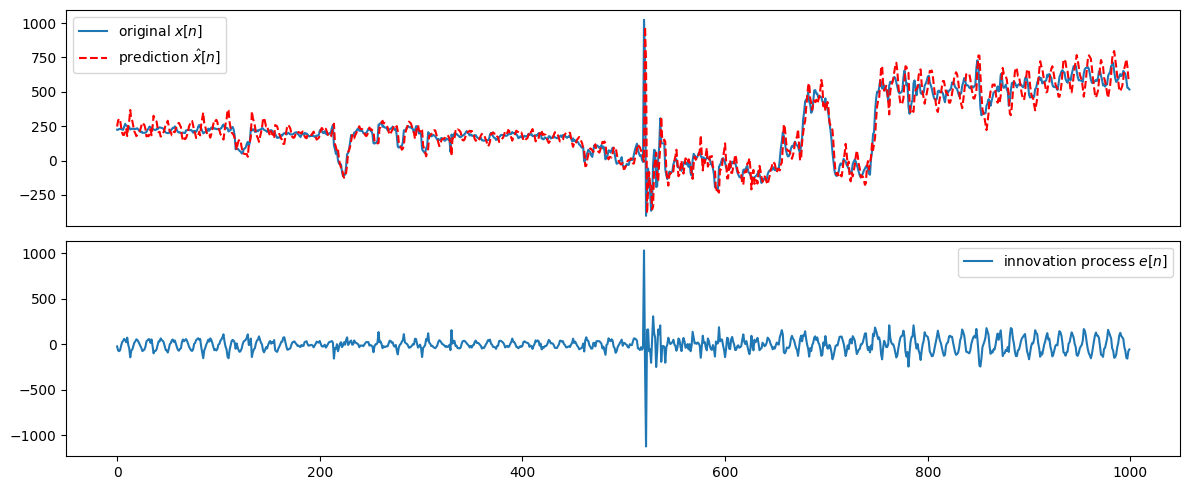

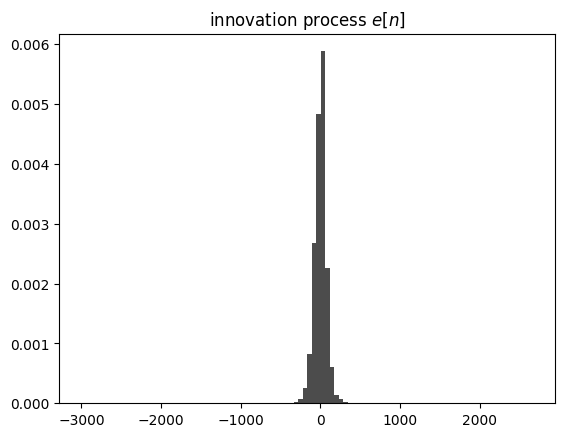

In [19]:
# zoom = slice(0,N)
# zoom = slice(1000,1100)
# zoom = slice(2000,3000)
zoom = slice(1600, 2600)


plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)

plt.plot(x_centered[zoom], label='original $x[n]$')
plt.plot(x_pred[zoom], 'r--', label='prediction $\hat{x}[n]$')
plt.xticks([])
plt.legend()

# resids - e
plt.subplot(2, 1, 2)
plt.plot(ar_inproc[zoom], label='innovation process $e[n]$')
plt.legend()

plt.tight_layout()
plt.show()


# e norm
plt.hist(ar_inproc, bins=100, density=True, alpha=0.7, color='k')
plt.title('innovation process $e[n]$')

plt.show()